In [254]:
import numpy as np
import matplotlib.pyplot as plt

class NeuralNet:
    """
    ...
    """

    FLOAT_TYPE = 'f4' # Float type for calculation

    def __init__(self, layers:tuple, WeightWeights=None,
                act_func='sigmoid', cost_func='SE', solver='gd',
                seed:int=None, alpha:float=1e0, maxiter:int=10, batchsize:int=-1):
        """
        Sets up the the settings of the neural network.
        """

        # Layers:
        self.layers = layers
        self.L = len(layers)
        if WeightWeights is None:
            self.WW = list([np.ones((self.layers[l],self.layers[l-1]), dtype=self.FLOAT_TYPE) for l in range(1,self.L)])
        else:
            self.WW = WeightWeights

        # Activiation Function:
        if act_func == 'sigmoid':
            self.act_func   = lambda x: 1.0/(1.0+np.exp(-x))
            self.act_deriv  = lambda x: 0.5/(1.0+np.cosh(x))

        # Cost Function:
        if cost_func == 'prob':
            self.cost_func  = lambda A,S: ((1-A)/A)**(2*S-1)
            self.cost_deriv = lambda A,S: (S+(2*S-1)*A)**-2
        elif cost_func == 'SE':
            self.cost_func  = lambda A,S: 0.5*(A-S)**2
            self.cost_deriv = lambda A,S: A-S
        elif cost_func == 'Other':
            # self.cost_deriv = lambda A,S: ((-1)**S)*((1-A)/A)**(2*S-1)
            self.cost_deriv = lambda A,S: (A-S)**1

        # Defining Solver:
        if type(solver) != str:     self.solver = solver
        elif solver == 'gd':        self.solver = self.__gradient_descent
        elif solver == 'sgd':       self.solver = self.__stochastic_gradient_descent

        # Hyperparameters:
        self.alpha     = alpha
        self.maxiter   = maxiter
        self.batchsize = batchsize

        # Random Number Generator Seed:
        if seed is None:   self.seed = np.random.randint(1000000000)
        else:                   self.seed = seed
        self.rng = np.random.default_rng(self.seed)

    def __forward_prop(self, l:int, A_):
        'performs forward propagation for one layer'

        Z = self.W[l-1] @ A_ + self.B[l-1]
        A = self.act_func(Z)
        return Z, A

    def __back_prop(self, l:int, Z, A, _dZ=None, S=None, m=1):
        'Performs back-propagation for one layer'

        if l == self.L-1:
            dZ = self.cost_deriv(A,S) * self.act_deriv(Z)
            dZ = A - S
            return dZ
        else:
            dZ  = (self.W[l].T @ _dZ) * self.act_deriv(Z)
            _dB = np.mean(_dZ, axis=1).reshape(-1,1)
            _dW = self.WW[l]*(_dZ @ A.T) / m
            return dZ, _dB, _dW

    def train(self, data, solution):
        'This method trains the neural network'

        # Error Checking:
        if data.shape[0] != self.layers[0]:         raise ValueError('Data must match size of the first layer')
        if solution.shape[0] != self.layers[-1]:    raise ValueError('Solutions must match size of the last layer')
        if data.shape[1] != solution.shape[1]:      raise ValueError('Data and solution must have the same sizes')

        # Initializing Weights and Biases:
        self.W = list([self.WW[l-1]*self.rng.normal(size=(self.layers[l],self.layers[l-1])) for l in range(1,self.L)])
        self.B = list([self.rng.normal(size=(num_neurons,1)) for num_neurons in self.layers[1:]])

        # Number of training cases
        if self.batchsize == -1:    m = solution.shape[1]
        else:                       m = self.batchsize

        # Defining Arrays:
        Z  = list(np.zeros((num_neurons,m), dtype=self.FLOAT_TYPE) for num_neurons in self.layers)
        A  = list(np.zeros((num_neurons,m), dtype=self.FLOAT_TYPE) for num_neurons in self.layers)
        dZ = list(np.zeros((num_neurons,m), dtype=self.FLOAT_TYPE) for num_neurons in self.layers)
        dB = list(np.zeros((num_neurons,1), dtype=self.FLOAT_TYPE) for num_neurons in self.layers[1:])
        dW = list(np.zeros((self.layers[l],self.layers[l-1]), dtype=self.FLOAT_TYPE) for l in range(1,self.L))

        # Iteration Loop:
        for iter in range(self.maxiter):

            # Get batch:
            if self.batchsize == -1:
                Z[0] = data
                S    = solution
            else:
                idx = np.arange(solution.shape[1])
                self.rng.shuffle(idx)
                Z[0] = data[:,idx[:m]]
                S    = solution[:,idx[:m]]
            A[0] = self.act_func(Z[0])

            # Forward Loop:
            for l in range(1,self.L):
                Z[l], A[l] = self.__forward_prop(l, A[l-1])
            
            # Backward Loop:
            l = self.L-1
            dZ[-1] = self.__back_prop(l, Z[l], A[l], S=S, m=m)
            for l in range(len(self.layers)-2,-1,-1):
                dZ[l], dB[l], dW[l] = self.__back_prop(l, Z[l], A[l], _dZ=dZ[l+1], m=m)

            # for l in range(1,self.L):
            #     print(f'l: {l},\t W: {self.W[l-1].shape},\t dW: {dW[l-1].shape},\t B: {self.B[l-1].shape},\t dB: {dB[l-1].shape},\t dZ: {dZ[l-1].shape}')

            # Descent:
            for l in range(self.L-1):
                self.B[l] = self.solver(self.B[l], dB[l])
                self.W[l] = self.solver(self.W[l], dW[l])

    def run(self, data):
        'Runs the neural network'

        A = self.act_func(data)
        for l in range(1,self.L):
            A = self.__forward_prop(l, A)[1]
        return A

    # =================================================================================
    #   Display Results:
    # =================================================================================

    def visualize(self, layer=0):
        'Visualizing the weights and biases of the neural network'

        plt.figure()
        plt.imshow(self.W[layer].T, cmap='hot', interpolation='nearest')
        plt.xlabel(f'Layer {layer+1}', fontsize=16)
        plt.ylabel(f'Layer {layer}'  , fontsize=16)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def ProbCorrPlot(Prob_Guess_All, Answer):
        'Plots the probability correlation'

        Answer = np.bool_(Answer)
        nBin = round(np.sqrt(len(Answer)))
        edges = np.linspace(0.0, 1.0, nBin+1)
        X = (edges[:-1] + edges[1:])/2
        Prob_Guess_Type = Prob_Guess_All
        Prob_Guess_Cor  = Prob_Guess_Type[Answer]
        Count_All = np.histogram(Prob_Guess_Type, bins=edges)[0]
        Count_Cor = np.histogram(Prob_Guess_Cor , bins=edges)[0]

        X2         = X[Count_All != 0]
        Count_All2 = Count_All[Count_All != 0]
        Count_Cor2 = Count_Cor[Count_All != 0]
        Prob_Ans_Cor = Count_Cor2/Count_All2
        Prob_Ans_Cor_SD = 1.0 / np.sqrt(Count_All2)

        plt.figure()
        plt.errorbar(X2,Prob_Ans_Cor,Prob_Ans_Cor_SD,capsize=3,ls='none',c='k')
        plt.scatter(X2,Prob_Ans_Cor,marker='.',s=14,c='k')
        plt.plot([0,1],[0,1],':b',lw=2,label='Ideal Correlation')
        Norm = 0.25/np.max(Count_All)
        plt.fill_between(X,Norm*Count_All,alpha=0.8,color=(0.1,0.5,0.1),label='Probability Density')
        
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.title('Probability Accuracy',fontsize=18)
        plt.xlabel('Predicted Probability',fontsize=15)
        plt.ylabel('Fraction of Correct Assignments',fontsize=15)
        plt.legend(fontsize=10)

        plt.show()

    @staticmethod
    def PrintScore(Guess, Answer):
        GuessInt = np.round(Guess)
        score = np.mean(GuessInt == Answer)
        print(f'Score: {100*score:.2f}%')

    # =================================================================================
    #   Solvers:
    # =================================================================================
    
    def __gradient_descent(self, X, dX):
        return X - self.alpha * dX


In [255]:
from this import d


class Sampler:

    def __init__(self, MLS, MA, MB, dE, N, NP, Grouping, BG, S):
        self.MLS = MLS
        self.MA  = MA
        self.MB  = MB
        self.dE  = dE

        self.N   = N
        self.NP  = NP
        self.Grouping = Grouping

        self.BG  = BG
        self.S   = S

        self.DE = Grouping*N*dE

    def __Noise(self, X):
        return np.random.poisson(self.S*X+self.BG)

    def sample(s):
        tail = int((s.NP-1)/2)
        E = s.dE * (np.arange(s.Grouping*s.N + 2*tail) - tail)

        NumRes = np.random.poisson(s.DE/s.MLS)
        El = np.random.uniform(low=0.0, high=s.DE, size=NumRes).reshape(1,-1)
        Ga = s.MA * abs(np.random.normal(size=NumRes)).reshape(1,-1)
        Gb = s.MB * abs(np.random.normal(size=NumRes)).reshape(1,-1)
        TrueData = np.sum(Ga*Gb / ((E.reshape(-1,1)-El)**2 + ((Ga+Gb)/2)**2), axis=1)
        Answer = np.array([(idx == np.round(El/(s.Grouping*s.dE))).any() for idx in range(s.N)], ndmin=2)
        RawData = s.__Noise(TrueData)
        Data = np.array([RawData[idx-tail:idx+tail+1] for idx in range(tail, s.Grouping*s.N+tail, s.Grouping)]).T
        return Data, Answer


In [256]:
# path = "/Users/colefritsch/ENCORE/Python_ENCORE/MissingNeuralNets"

# with open(f'{path}/1e4_samples_50epts_corrected/residual_data.csv', 'r') as file:
#     data = file.read()
# Data = np.array([[float(el) for el in row.split(',')] for row in data.split('\n')[:-1]]).T

# with open(f'{path}/1e4_samples_50epts_corrected/missing_res_.csv', 'r') as file:
#     data = file.read()
# Num = np.array([int(el[0]) for el in data.split('\n')[:-1]], ndmin=2)
# Ans = np.int_(Num >= 1)

# neural_net = NeuralNet((NP,1), alpha=1e-2, maxiter=50000, batchsize=10, cost_func='SE')
# neural_net.train(Data[:,:5000], Ans[:,:5000])

# Guesses = neural_net.run(Data[:,5000:])
# Answers = Ans[:,5000:]

MLS = 3         # Mean Level Spacing
MA = 0.6        # Mean Width 1
MB = 0.03       # Mean Width 2
dE = 0.08       # Energy Spacing

N = 10000       # Number of train/test cases
NP = 15         # Number of data points in search space
Grouping = 5    # Number of points in a group considered for a resonance

BG = 3.5        # Background Index
S  = 25         # Samples Index

WW = [np.array([[1,1,1,1]])]

neural_net = NeuralNet((NP,2,1,1), alpha=4e-1, maxiter=100000, batchsize=10, cost_func='prob')

SAMPLER = Sampler(MLS, MA, MB, dE, N, NP, Grouping, BG, S)
Data, Ans = SAMPLER.sample()
neural_net.train(Data, Ans)

GuessesTrain = neural_net.run(Data)
AnswersTrain = Ans

SAMPLER = Sampler(MLS, MA, MB, dE, N, NP, Grouping, BG, S)
Data, Ans = SAMPLER.sample()

Guesses = neural_net.run(Data)
Answers = Ans

# print(np.concatenate((Guesses.T, Ans.T), axis=1))


Train:
Score: 87.50%


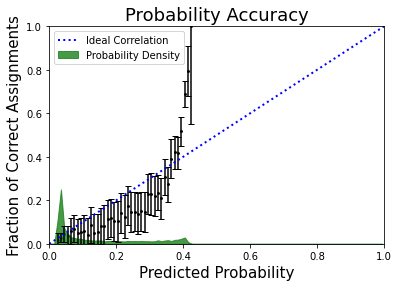


Test:
Score: 87.34%


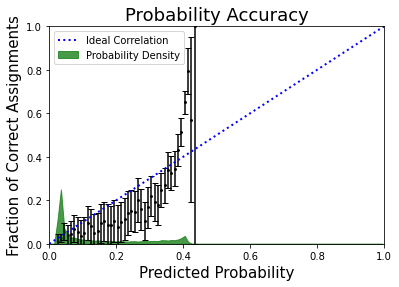

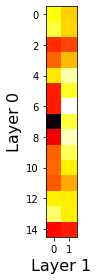

In [257]:
import matplotlib.pyplot as plt

print('\nTrain:')
NeuralNet.PrintScore(GuessesTrain, AnswersTrain)
NeuralNet.ProbCorrPlot(GuessesTrain.reshape(-1), AnswersTrain.reshape(-1))

print('\nTest:')
NeuralNet.PrintScore(Guesses, Answers)
NeuralNet.ProbCorrPlot(Guesses.reshape(-1), Answers.reshape(-1))

neural_net.visualize(0)